# Classificação dos pokemons inicias da primeira geração

Alexandre Borges Baccarini Júnior - 2515520

Leonardo - 25

Mateus - 25

## 1. Instalação e Importação de Bibliotecas

Execute a célula abaixo apenas uma vez para instalar as dependências necessárias.

In [ ]:
# Instale as bibliotecas necessárias (execute apenas uma vez)
%pip install numpy pandas Pillow scikit-learn keras imblearn scikit-image

## 2. Definição dos Descritores e Funções de Extração

Funções para extração de características manuais (LBP, LPQ) e profundas (VGG16).

In [ ]:
# Importação das bibliotecas necessárias para extração de características
import os
import numpy as np
import pandas as pd
from PIL import Image
from typing import Literal
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d
from scipy.spatial.distance import cdist

# Função para extrair descritor LBP (Local Binary Pattern)
def lbp(image: np.ndarray, 
        P: int = 8, 
        R: int = 2, 
        method: Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform'):
    """
    Extrai o histograma LBP de uma imagem em escala de cinza.
    """
    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    desc = local_binary_pattern(image, P, R, method=method)
    n_bins = int(desc.max() + 1)
    hist, _ = np.histogram(desc, density=True, bins=n_bins, range=(0, n_bins))
    return hist

# Função para extrair descritor LPQ (Local Phase Quantization)
def lpq(img, winSize=7, decorr=1, mode='nh'):
    """
    Extrai o descritor LPQ de uma imagem em escala de cinza.
    """
    rho = 0.90
    STFTalpha = 1/winSize
    convmode = 'valid'
    
    img = np.float64(img)
    r = (winSize-1)/2
    x = np.arange(-r, r+1)[np.newaxis]
    
    # STFT filters
    w0 = np.ones_like(x)
    w1 = np.exp(-2*np.pi*x*STFTalpha*1j)
    w2 = np.conj(w1)
    
    # Filter responses
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)
    
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                         filterResp2.real, filterResp2.imag,
                         filterResp3.real, filterResp3.imag,
                         filterResp4.real, filterResp4.imag])
    
    if decorr == 1:
        pass
    
    # Quantization and LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0) * (2**inds)).sum(2)
    
    if mode == 'nh' or mode == 'h':
        LPQdesc = np.histogram(LPQdesc.flatten(), range(257))[0]
    if mode == 'nh':
        LPQdesc = LPQdesc / LPQdesc.sum()
    
    return LPQdesc

# Função para extrair características manuais (LBP ou LPQ) de um diretório de imagens
def extract_handcrafted_features(directory, descriptor='lbp', **kwargs):
    features = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(directory, filename)
            # Corrigir para pegar o nome da classe (personagem)
            label = os.path.basename(os.path.dirname(directory))
            try:
                image = Image.open(img_path).convert('L')  # Grayscale
                image = np.array(image)
                
                if descriptor == 'lbp':
                    feat = lbp(image, **kwargs)
                elif descriptor == 'lpq':
                    feat = lpq(image, **kwargs)
                
                features.append(feat)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    return features, labels

# Importação do modelo VGG16 para extração de características profundas
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA

# Função para extrair características profundas usando VGG16 e aplicar PCA opcionalmente
def extract_deep_features(directory, target_size=(224, 224), pca_components=None, pca_model=None):
    """Extrai características profundas usando VGG16 com PCA opcional"""
    model = VGG16(weights='imagenet', include_top=False)
    features = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(directory, filename)
            # Corrigir para pegar o nome da classe (personagem)
            label = os.path.basename(os.path.dirname(directory))
            try:
                img = Image.open(img_path).convert('RGB').resize(target_size)
                img = np.array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                
                feature = model.predict(img, verbose=0).flatten()
                features.append(feature)
                labels.append(label)
            except Exception as e:
                print(f"Erro ao processar {img_path}: {str(e)}")
    
    features = np.array(features)
    if pca_components and len(features) > 0:
        if pca_model is None:
            n_samples = len(features)
            actual_components = min(pca_components, n_samples, features.shape[1])
            if actual_components < pca_components:
                print(f"Aviso: Reduzindo componentes PCA de {pca_components} para {actual_components}")
            pca = PCA(n_components=actual_components)
            features = pca.fit_transform(features)
            return features, labels, pca
        else:
            features = pca_model.transform(features)
            return features, labels, pca_model
    return features, labels, None

# Função para processar um conjunto de diretórios, extrair e combinar características, e salvar em CSV
def process_dataset(dirs, output_path, pca_components=50, lbp_params={'descriptor': 'lbp', 'P': 8, 'R': 2}, pca_model=None):
    """
    Processa um conjunto de dados completo, extrai características profundas e manuais,
    combina os vetores e salva em arquivo CSV.
    """
    # Extrai características profundas
    deep_features = []
    deep_labels = []
    pca = pca_model
    for dir in dirs:
        feats, lbls, pca = extract_deep_features(dir, pca_components=pca_components, pca_model=pca)
        deep_features.extend(feats)
        deep_labels.extend(lbls)

    # Extrai características manuais (LBP)
    handcrafted_features = []
    handcrafted_labels = []
    for dir in dirs:
        feats, lbls = extract_handcrafted_features(dir, **lbp_params)
        handcrafted_features.extend(feats)
        handcrafted_labels.extend(lbls)

    # Verifica se temos o mesmo número de amostras
    min_samples = min(len(deep_features), len(handcrafted_features))
    if len(deep_features) != len(handcrafted_features):
        print(f"Aviso: Número diferente de amostras (deep: {len(deep_features)}, hand: {len(handcrafted_features)})")
        print(f"Usando apenas as primeiras {min_samples} amostras de cada")
        deep_features = deep_features[:min_samples]
        handcrafted_features = handcrafted_features[:min_samples]
        deep_labels = deep_labels[:min_samples]

    # Debug: imprime tamanhos dos vetores
    print(f"Tamanho deep_features[0]: {len(deep_features[0])}")
    print(f"Tamanho handcrafted_features[0]: {len(handcrafted_features[0])}")

    # Combina características
    combined_features = []
    for deep, hand in zip(deep_features, handcrafted_features):
        if len(deep) != len(deep_features[0]) or len(hand) != len(handcrafted_features[0]):
            print(f"Vetor com tamanho diferente detectado! Deep: {len(deep)}, Hand: {len(hand)}")
            continue
        try:
            combined = np.concatenate([deep, hand])
            combined_features.append(combined)
        except ValueError as e:
            print(f"Erro ao combinar características: {str(e)}")
            continue

    if not combined_features:
        raise ValueError("Nenhuma característica válida foi combinada")

    # Cria DataFrame
    feature_length = len(combined_features[0])
    df_data = {'class': deep_labels[:len(combined_features)]}
    
    for i in range(feature_length):
        df_data[f'feature_{i}'] = [vec[i] for vec in combined_features]
    
    df = pd.DataFrame(df_data)
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)
    
    print(f"\nExtração concluída para {output_path}")
    print(f"Total de amostras: {len(combined_features)}")
    print(f"Tamanho do vetor de características: {feature_length}")
    return pca

# Diretórios de treino e teste
train_dirs = [
    "./datasets/Bulbasaur/Train",
    "./datasets/Charmander/Train",
    "./datasets/Squirtle/Train",
]

test_dirs = [
    "./datasets/Bulbasaur/Valid",
    "./datasets/Charmander/Valid",
    "./datasets/Squirtle/Valid",
]

# Processa os conjuntos de dados de treino e teste, salvando os vetores combinados em CSV
try:
    print("Processando dados de treino...")
    pca_model = process_dataset(train_dirs, "./data/Train/combined_features.csv", pca_components=50)
    
    print("\nProcessando dados de teste...")
    process_dataset(test_dirs, "./data/Valid/combined_features.csv", pca_components=50, pca_model=pca_model)
except Exception as e:
    print(f"\nErro durante o processamento: {str(e)}")

2025-06-29 21:02:21.800628: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 21:02:21.927848: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 21:02:22.047673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751241742.160176    4509 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751241742.192178    4509 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751241742.393861    4509 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Processando dados de treino...


2025-06-29 21:02:26.679904: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-29 21:02:27.643691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-06-29 21:02:27.695659: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-06-29 21:02:28.047955: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-06-29 21:02:28.055848: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.
2025-06-29 21:02:28.423713: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12845056 exceeds 10% of free system memory.


Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Train/combined_features.csv
Total de amostras: 337
Tamanho do vetor de características: 109

Processando dados de teste...
Tamanho deep_features[0]: 50
Tamanho handcrafted_features[0]: 59

Extração concluída para ./data/Valid/combined_features.csv
Total de amostras: 121
Tamanho do vetor de características: 109


## 4. Treinamento e Avaliação dos Modelos

Nesta seção, treinamos e avaliamos diferentes modelos de classificação: k-NN, SVM e Árvore de Decisão.

### 4.1 Treinamento e Avaliação do k-NN

In [ ]:
# Importação das bibliotecas para treinamento e avaliação do k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Carregar dados de treino
train_df = pd.read_csv("./data/Train/combined_features.csv")

# Pré-processamento: separa X (características) e y (rótulos)
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Pipeline com balanceamento (SMOTE), normalização e PCA
pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42),
    PCA(n_components=0.95),
    KNeighborsClassifier()
)

# Grade de parâmetros para busca em grade (GridSearch)
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'cosine'],
    'kneighborsclassifier__p': [1, 2],
    'pca__n_components': [0.85, 0.90, 0.95, None]
}
print("Distribuição das classes no treino:", np.bincount(y_train_encoded))
# Busca em grade com validação cruzada estratificada
grid_knn = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Treinamento do modelo k-NN com busca em grade
grid_knn.fit(X_train, y_train_encoded)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros KNN:")
print(grid_knn.best_params_)
print(f"Melhor F1-score: {grid_knn.best_score_:.4f}")

# Avaliação cruzada com melhores parâmetros (F1-score)
cv_scores_f1 = cross_val_score(
    grid_knn.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada (F1): {cv_scores_f1}")
print(f"Média F1-score: {np.mean(cv_scores_f1):.4f} (±{np.std(cv_scores_f1):.4f})")

# Avaliação cruzada com melhores parâmetros (Acurácia)
from sklearn.metrics import make_scorer, accuracy_score
cv_scores_acc = cross_val_score(
    grid_knn.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='accuracy'
)
print(f"Scores de validação cruzada (Acurácia): {cv_scores_acc}")
print(f"Média Acurácia: {np.mean(cv_scores_acc):.4f} (±{np.std(cv_scores_acc):.4f})")

Distribuição das classes no treino: [107  95 135]
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Melhores parâmetros KNN:
{'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance', 'pca__n_components': 0.85}
Melhor F1-score: 0.7146
Scores de validação cruzada (F1): [0.66992888 0.67993755 0.77398794 0.58293135 0.69581474]
Média F1-score: 0.6805 (±0.0610)
Scores de validação cruzada (Acurácia): [0.67647059 0.69117647 0.7761194  0.58208955 0.70149254]
Média Acurácia: 0.6855 (±0.0621)



Acurácia no conjunto de teste: 0.7355

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.73      0.85        41
  Charmander       0.59      0.86      0.70        35
    Squirtle       0.72      0.64      0.68        45

    accuracy                           0.74       121
   macro avg       0.77      0.74      0.74       121
weighted avg       0.78      0.74      0.74       121


Matriz de Confusão:


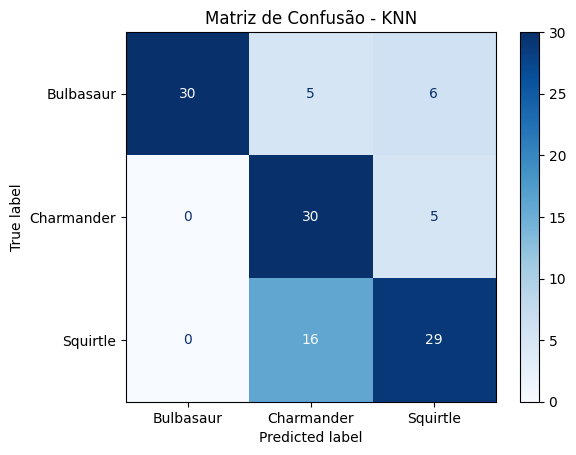

In [ ]:
# Avaliação do melhor modelo k-NN no conjunto de teste

from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Carregar dados de teste
test_df = pd.read_csv("./data/Valid/combined_features.csv")
X_test = test_df.drop('class', axis=1)
y_test = le.transform(test_df['class'])

# Melhor modelo KNN encontrado na busca em grade
best_knn = grid_knn.best_estimator_

# Predição no conjunto de teste e avaliação
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nAcurácia no conjunto de teste: {acc:.4f}")

print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - KNN')
plt.show()

### 4.2 Treinamento e Avaliação do SVM

In [ ]:
# Treinamento e avaliação do modelo SVM com busca aleatória de hiperparâmetros

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Pipeline para SVM com normalização, PCA, balanceamento e SVC
svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(),
    SMOTE(random_state=42),
    SVC(probability=True)
)

# Distribuições de parâmetros para busca aleatória (RandomizedSearchCV)
param_dist = {
    'pca__n_components': [50, 100, 150, None],
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-3, 1e3),
    'svc__kernel': ['rbf', 'linear', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': [None, 'balanced']
}

# Busca aleatória com validação cruzada
random_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Treinamento do modelo SVM
random_svm.fit(X_train, y_train_encoded)

# Resultados dos melhores parâmetros
print("Melhores parâmetros SVM:")
print(random_svm.best_params_)
print(f"Melhor F1-score: {random_svm.best_score_:.4f}")

# Avaliação cruzada do melhor modelo SVM
svm_scores = cross_val_score(
    random_svm.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada (Acurácia): {svm_scores}")
print(f"Média Acurácia: {np.mean(svm_scores):.4f} (±{np.std(svm_scores):.4f})")

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/alexandre/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alexandre/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandre/.local/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/alexandre/.local/lib/python3.10/site-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_param

Melhores parâmetros SVM:
{'pca__n_components': None, 'svc__C': np.float64(0.007197818769068854), 'svc__class_weight': None, 'svc__degree': 3, 'svc__gamma': np.float64(0.0021800651586435186), 'svc__kernel': 'linear'}
Melhor F1-score: 0.7852
Scores de validação cruzada (Acurácia): [0.73572589 0.80598758 0.76833744 0.80653236 0.80945483]
Média Acurácia: 0.7852 (±0.0290)



Acurácia no conjunto de teste (SVM): 0.8099

Relatório de Classificação - SVM (Teste):
              precision    recall  f1-score   support

   Bulbasaur       0.89      0.83      0.86        41
  Charmander       0.74      0.83      0.78        35
    Squirtle       0.80      0.78      0.79        45

    accuracy                           0.81       121
   macro avg       0.81      0.81      0.81       121
weighted avg       0.81      0.81      0.81       121


Matriz de Confusão - SVM:


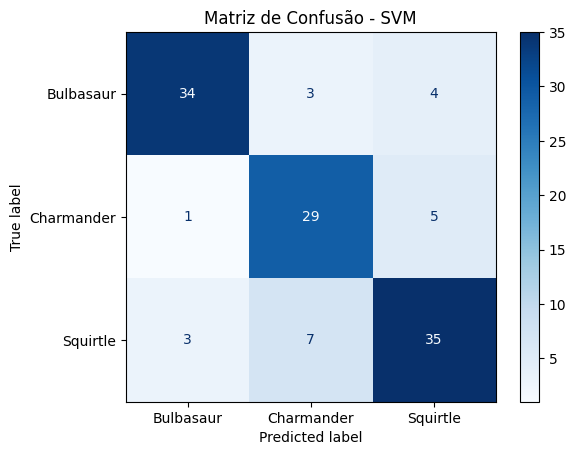

In [ ]:
# Avaliação do melhor modelo SVM no conjunto de teste

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Melhor modelo SVM encontrado
best_svm = random_svm.best_estimator_

# Predição e avaliação no conjunto de teste
y_pred_svm = best_svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAcurácia no conjunto de teste (SVM): {acc_svm:.4f}")

print("\nRelatório de Classificação - SVM (Teste):")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("\nMatriz de Confusão - SVM:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - SVM')
plt.show()

### 4.3 Treinamento e Avaliação da Árvore de Decisão

In [ ]:
# Treinamento e avaliação do modelo Árvore de Decisão com Bagging

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Pipeline para Árvore de Decisão com normalização, balanceamento e Bagging
tree_pipeline = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42),
    BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators=10,
        random_state=42
    )
)

# Grade de parâmetros para busca em grade (GridSearch)
tree_params = {
    'baggingclassifier__estimator__criterion': ['gini', 'entropy'],
    'baggingclassifier__estimator__max_depth': [None, 10, 20, 30],
    'baggingclassifier__estimator__min_samples_split': [2, 5, 10],
    'baggingclassifier__estimator__min_samples_leaf': [1, 2, 4],
    'baggingclassifier__estimator__max_features': ['sqrt', 'log2', None],
    'baggingclassifier__estimator__class_weight': [None, 'balanced']
}

# Busca em grade para encontrar melhores hiperparâmetros
grid_tree = GridSearchCV(
    tree_pipeline,
    tree_params,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Treinamento do modelo Árvore de Decisão
grid_tree.fit(X_train, y_train_encoded)

# Resultados dos melhores parâmetros
print("Melhores parâmetros Árvore de Decisão:")
print(grid_tree.best_params_)
print(f"Melhor F1-score: {grid_tree.best_score_:.4f}")

# Avaliação cruzada do melhor modelo Árvore de Decisão
tree_scores = cross_val_score(
    grid_tree.best_estimator_,
    X_train,
    y_train_encoded,
    cv=5,
    scoring='f1_macro'
)
print(f"Scores de validação cruzada: {tree_scores}")
print(f"Média F1-score: {np.mean(tree_scores):.4f} (±{np.std(tree_scores):.4f})")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Melhores parâmetros Árvore de Decisão:
{'baggingclassifier__estimator__class_weight': None, 'baggingclassifier__estimator__criterion': 'entropy', 'baggingclassifier__estimator__max_depth': 10, 'baggingclassifier__estimator__max_features': 'sqrt', 'baggingclassifier__estimator__min_samples_leaf': 2, 'baggingclassifier__estimator__min_samples_split': 10}
Melhor F1-score: 0.8707
Scores de validação cruzada: [0.86897922 0.86152964 0.86866347 0.86362853 0.89065256]
Média F1-score: 0.8707 (±0.0104)



Acurácia no conjunto de teste (Árvore): 0.8678

Relatório de Classificação - Árvore (Teste):
              precision    recall  f1-score   support

   Bulbasaur       0.86      0.93      0.89        41
  Charmander       0.93      0.77      0.84        35
    Squirtle       0.83      0.89      0.86        45

    accuracy                           0.87       121
   macro avg       0.88      0.86      0.87       121
weighted avg       0.87      0.87      0.87       121


Matriz de Confusão - Árvore:


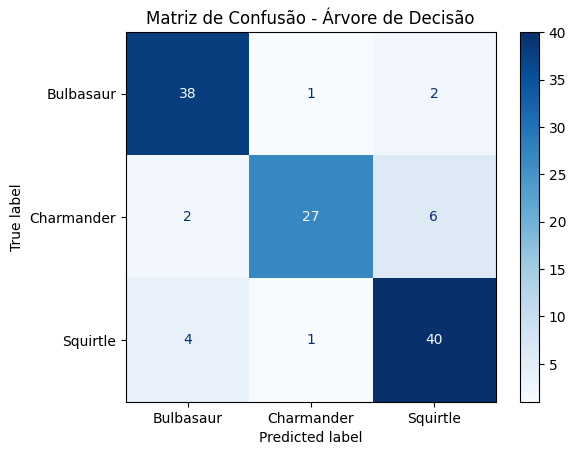

In [ ]:
# Avaliação do melhor modelo Árvore de Decisão no conjunto de teste

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Melhor modelo de Árvore de Decisão encontrado
best_tree = grid_tree.best_estimator_

# Predição e avaliação no conjunto de teste
y_pred_tree = best_tree.predict(X_test)

acc_tree = accuracy_score(y_test, y_pred_tree)
print(f"\nAcurácia no conjunto de teste (Árvore): {acc_tree:.4f}")

print("\nRelatório de Classificação - Árvore (Teste):")
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))

print("\nMatriz de Confusão - Árvore:")
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()

## 5. Salvando e Reutilizando os Modelos

In [ ]:
# Salvando os melhores modelos treinados para uso futuro

import joblib

# Salvar o melhor modelo k-NN
joblib.dump(best_knn, 'saved_models/best_knn_model.joblib')

# Salvar o melhor modelo SVM
joblib.dump(best_svm, 'saved_models/best_svm_model.joblib')

# Salvar o melhor modelo Árvore de Decisão
joblib.dump(best_tree, 'saved_models/best_tree_model.joblib')

['saved_models/best_tree_model.joblib']

Acurácia k-NN: 0.7355371900826446
Relatório k-NN:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85        41
           1       0.59      0.86      0.70        35
           2       0.72      0.64      0.68        45

    accuracy                           0.74       121
   macro avg       0.77      0.74      0.74       121
weighted avg       0.78      0.74      0.74       121



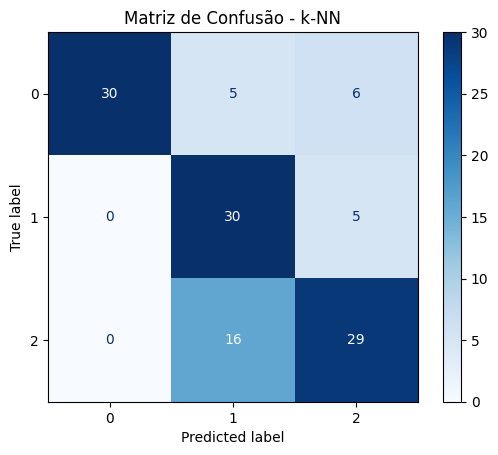

Acurácia SVM: 0.8099173553719008
Relatório SVM:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        41
           1       0.74      0.83      0.78        35
           2       0.80      0.78      0.79        45

    accuracy                           0.81       121
   macro avg       0.81      0.81      0.81       121
weighted avg       0.81      0.81      0.81       121



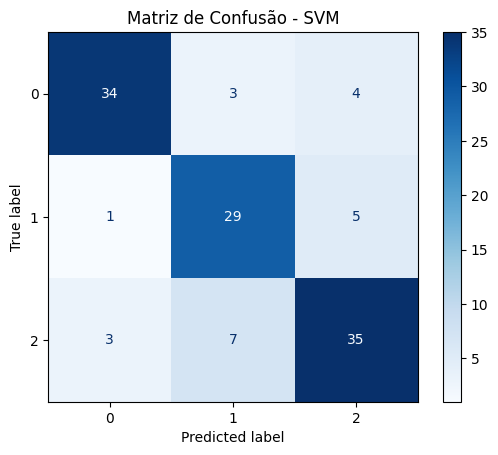

Acurácia Árvore de Decisão: 0.8677685950413223
Relatório Árvore de Decisão:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89        41
           1       0.93      0.77      0.84        35
           2       0.83      0.89      0.86        45

    accuracy                           0.87       121
   macro avg       0.88      0.86      0.87       121
weighted avg       0.87      0.87      0.87       121



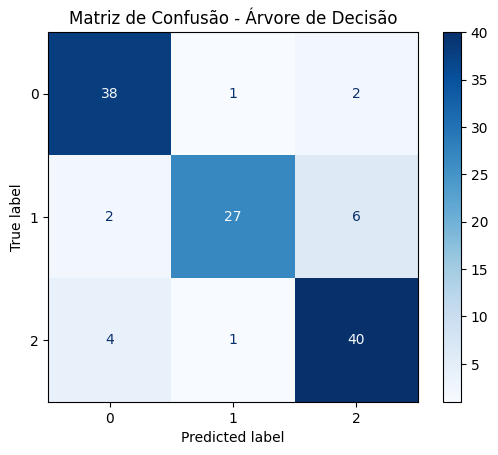

In [2]:
# Exemplo de como carregar e reutilizar os modelos salvos

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Carregar dados de teste
test_df = pd.read_csv("./data/Valid/combined_features.csv")
X_test = test_df.drop('class', axis=1)
y_test_labels = test_df['class']
le = LabelEncoder()
le.fit(['Bulbasaur', 'Charmander', 'Squirtle'])
y_test = le.transform(y_test_labels)

# Carregar o modelo k-NN salvo e avaliar no conjunto de teste
best_knn = joblib.load('saved_models/best_knn_model.joblib')
y_pred_knn = best_knn.predict(X_test)
print("Acurácia k-NN:", accuracy_score(y_test, y_pred_knn))
print("Relatório k-NN:\n", classification_report(y_test, y_pred_knn))
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - k-NN')
plt.show()

# Carregar o modelo SVM salvo e avaliar no conjunto de teste
best_svm = joblib.load('saved_models/best_svm_model.joblib')
y_pred_svm = best_svm.predict(X_test)
print("Acurácia SVM:", accuracy_score(y_test, y_pred_svm))
print("Relatório SVM:\n", classification_report(y_test, y_pred_svm))
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - SVM')
plt.show()

# Carregar o modelo Árvore de Decisão salvo e avaliar no conjunto de teste
best_tree = joblib.load('saved_models/best_tree_model.joblib')
y_pred_tree = best_tree.predict(X_test)
print("Acurácia Árvore de Decisão:", accuracy_score(y_test, y_pred_tree))
print("Relatório Árvore de Decisão:\n", classification_report(y_test, y_pred_tree))
cm_tree = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(cm_tree).plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.show()